In [33]:
#1
import pandas as pd
import numpy as np
import json

import psycopg2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import xgboost as xgb
from sklearn import metrics
from xgboost import plot_importance
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor   
import seaborn as sns
%matplotlib inline
import pickle
import gc
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
plt.style.use('bmh')
from pandas import Series, DataFrame
from sklearn.model_selection import GridSearchCV


from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

import math
import traceback
import sys
import re
import datetime
datetime.timedelta()

datetime.timedelta(0)

In [45]:
def ks(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 10,duplicates='drop')
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100

    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True) 
    pd.set_option('display.max_columns', 9)
    #print(kstable)
     #Display KS
    from colorama import Fore
    print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return(kstable)


In [46]:
#####Function to generate VIF
def getVif(df,dep_var):
    try:
        dep = df[dep_var]
    except ValueError:
        print("Value error has occured")
    try:
        df_num = df.drop([dep_var], axis = 1)
    except ValueError:
        print("Value error has occured")
    try:
        df_num = df_num._get_numeric_data()
    except ValueError:
        print("Value error has occured")
    try:
        vif = pd.DataFrame()
    except IOError:
        print("Input Output error has occured")
    try:
        vif["VIF Factor"] = [variance_inflation_factor(df_num.values, i) for i in range(df_num.shape[1])]
        vif["Features"] = df_num.columns
    except ValueError:
        print("Value error has occured")
    try:
        return(vif)
    except IOError:
        print("Input Output error has occured")
         
    except:
        print("Error has occured")
        

In [47]:
def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    
    dset = dset.sort_values(by='WoE')
    
    return dset, iv

In [48]:
def adding_paid(data,paid):
    temp=pd.merge(data,paid,how='left',left_on='Loan_ID',right_on='loan_id')
    temp['paid_flag']=temp['paid_flag'].fillna(0)
    return temp

## Data Loading 

In [49]:
##Script-1 data
Jan22_ST1=pd.read_csv('data/input_data/processed_data/KB_Jan22_ST1.csv')
Feb22_ST1=pd.read_csv('data/input_data/processed_data/KB_Feb22_ST1.csv')
Mar22_ST1=pd.read_csv('data/input_data/processed_data/KB_Mar22_ST1.csv')
Apr22_ST1=pd.read_csv('data/input_data/processed_data/KB_Apr22_ST1.csv')
May22_ST1=pd.read_csv('data/input_data/processed_data/RR_May22_ST1.csv')
June22_ST1=pd.read_csv('data/input_data/processed_data/RR_June22_ST1.csv')
July22_ST1=pd.read_csv('data/input_data/processed_data/RR_Jul22_ST1.csv')

Jan22_ST1['month']=1
Feb22_ST1['month']=2
Mar22_ST1['month']=3
Apr22_ST1['month']=4
May22_ST1['month']=5
June22_ST1['month']=6
July22_ST1['month']=7


Jan22_ST1.shape
Feb22_ST1.shape
Mar22_ST1.shape
Apr22_ST1.shape
May22_ST1.shape
June22_ST1.shape
July22_ST1.shape

##concating the data
ST1=pd.concat([Jan22_ST1,Feb22_ST1,Mar22_ST1,Apr22_ST1,May22_ST1,June22_ST1,July22_ST1])

(44900, 12)

(46173, 12)

(36442, 12)

(39281, 12)

(39773, 10)

(34159, 10)

(37467, 10)

In [50]:
##Script-2 data
Jan22_ST2=pd.read_csv('data/input_data/processed_data/KB_Jan22_last3_calls_ST2.csv')
Feb22_ST2=pd.read_csv('data/input_data/processed_data/KB_Feb22_last3_calls_ST2.csv')
Mar22_ST2=pd.read_csv('data/input_data/processed_data/KB_Mar22_last3_calls_ST2.csv')
Apr22_ST2=pd.read_csv('data/input_data/processed_data/KB_Apr22_last3_calls_ST2.csv')
May22_ST2=pd.read_csv('data/input_data/processed_data/RR_May22_last3_calls_ST2.csv')
June22_ST2=pd.read_csv('data/input_data/processed_data/RR_June22_last3_calls_ST2.csv')
July22_ST2=pd.read_csv('data/input_data/processed_data/RR_Jul22_last3_calls_ST2.csv')

Jan22_ST2['month']=1
Feb22_ST2['month']=2
Mar22_ST2['month']=3
Apr22_ST2['month']=4
May22_ST2['month']=5
June22_ST2['month']=6
July22_ST2['month']=7

Jan22_ST2.shape
Feb22_ST2.shape
Mar22_ST2.shape
Apr22_ST2.shape
May22_ST2.shape
June22_ST2.shape
July22_ST2.shape

##concating the data
ST2=pd.concat([Jan22_ST2,Feb22_ST2,Mar22_ST2,Apr22_ST2,May22_ST2,June22_ST2,July22_ST2])

(44900, 176)

(46173, 176)

(36442, 176)

(39281, 176)

(39773, 175)

(34159, 175)

(37467, 175)

In [51]:
##Script-3 data
Jan22_ST3=pd.read_csv('data/input_data/processed_data/KB_Jan22_loan_ST3.csv')
Feb22_ST3=pd.read_csv('data/input_data/processed_data/KB_Feb22_loan_ST3.csv')
Mar22_ST3=pd.read_csv('data/input_data/processed_data/KB_Mar22_loan_ST3.csv')
Apr22_ST3=pd.read_csv('data/input_data/processed_data/KB_Apr22_loan_ST3.csv')
May22_ST3=pd.read_csv('data/input_data/processed_data/RR_May22_loan_ST3.csv')
June22_ST3=pd.read_csv('data/input_data/processed_data/RR_June22_loan_ST3.csv')
July22_ST3=pd.read_csv('data/input_data/processed_data/RR_Jul22_loan_ST3.csv')

Jan22_ST3['month']=1
Feb22_ST3['month']=2
Mar22_ST3['month']=3
Apr22_ST3['month']=4
May22_ST3['month']=5
June22_ST3['month']=6
July22_ST3['month']=7

Jan22_ST3.shape
Feb22_ST3.shape
Mar22_ST3.shape
Apr22_ST3.shape
May22_ST3.shape
June22_ST3.shape
July22_ST3.shape

#Adding payment file into ST3:
may_paid=pd.read_excel('data/input_data/raw_data/may22_paid_RR.xlsx')
may_paid['paid_flag']=1
may_paid=may_paid.rename(columns={'AgreementNumber':'loan_id'})
May22_ST3=adding_paid(May22_ST3,may_paid[['loan_id','paid_flag']])

june_paid=pd.read_excel('data/input_data/raw_data/june22_paid_RR.xlsx')
june_paid['paid_flag']=1
june_paid=june_paid.rename(columns={'AgreementNumber':'loan_id'})
June22_ST3=adding_paid(June22_ST3,june_paid[['loan_id','paid_flag']])

july_paid=pd.read_excel('data/input_data/raw_data/july22_paid_RR.xlsx')
july_paid['paid_flag']=1
july_paid=july_paid.rename(columns={'AgreementNumber':'loan_id'})
July22_ST3=adding_paid(July22_ST3,july_paid[['loan_id','paid_flag']])

##concating the data
ST3=pd.concat([Jan22_ST3,Feb22_ST3,Mar22_ST3,Apr22_ST3,May22_ST3,June22_ST3,July22_ST3])

(44900, 13)

(46173, 13)

(36442, 13)

(34159, 13)

(39773, 11)

(34159, 11)

(37467, 11)

In [52]:
ST1.shape
ST2.shape
ST3.shape

(278195, 12)

(278195, 176)

(273449, 15)

In [53]:
ST1.drop(['Unnamed: 0','paid_flag'],axis=1,inplace=True)
ST2.drop(['Unnamed: 0','L3_index'],axis=1,inplace=True)
ST3.drop(['Unnamed: 0'],axis=1,inplace=True)

In [54]:
## merging all ST1 & ST2 & ST3 data

ST3['Loan_ID']=ST3['Loan_ID'].astype(int).astype(str)
ST2['L3_Loan_ID']=ST2['L3_Loan_ID'].astype(int).astype(str)
ST1['Loan_ID']=ST1['Loan_ID'].astype(int).astype(str)

df_temp=pd.merge(ST3,ST2,how='left',left_on=['month','Loan_ID'],right_on=['month','L3_Loan_ID'])
df_temp.shape
df_final=pd.merge(df_temp,ST1,how='left',left_on=['month','Loan_ID'],right_on=['month','Loan_ID'])
df_final.shape

(273449, 187)

(273449, 195)

In [55]:
df=df_final.copy()

## EDA 

In [56]:
## Ration between 0/1
for i in range(1,8,1):
    print("Month : ",i)
    df[df['month']==i].paid_flag.value_counts(normalize=True)*100

Month :  1


0.0    97.008909
1.0     2.991091
Name: paid_flag, dtype: float64

Month :  2


0.0    97.18017
1.0     2.81983
Name: paid_flag, dtype: float64

Month :  3


0.0    97.250425
1.0     2.749575
Name: paid_flag, dtype: float64

Month :  4


0.0    97.982962
1.0     2.017038
Name: paid_flag, dtype: float64

Month :  5


0.0    97.275505
1.0     2.724495
Name: paid_flag, dtype: float64

Month :  6


0.0    97.642419
1.0     2.357581
Name: paid_flag, dtype: float64

Month :  7


0.0    97.077983
1.0     2.922017
Name: paid_flag, dtype: float64

## Feature Selection

In [57]:
## Selecting columns based on higher IV values:
sel_col=[
'month',
'Loan_ID',
'mean_call_duration',
'call_picked_%',
'call_response_%',
'L2_call_duration',
'L2_call_picked',
'L2_call_responsive',
'L2_Promiseto Pay',
'L2_RPC',
'L1_call_duration',
'L1_call_picked',
'L1_call_responsive',
'L1_Promiseto Pay',
'L1_RPC',
'Principle_due_%',
# 'Charges_due_%',
'Panelty_due_%',
'Principle_paid_%',
'paid_flag'    
]
df1=df[sel_col]

In [58]:
#downloading data for cross_check:
df1.to_csv('ITP_model_data.csv',index=False)

In [59]:
#dropping_columns
df1.drop(['call_picked_%'],axis=1,inplace=True)

## Feature Engineering

In [86]:
df1=df1.fillna(0)
df1=round(df1,2)

In [87]:
df1.isnull().sum()

month                 0
Loan_ID               0
mean_call_duration    0
call_response_%       0
L2_call_duration      0
L2_call_picked        0
L2_call_responsive    0
L2_Promiseto Pay      0
L2_RPC                0
L1_call_duration      0
L1_call_picked        0
L1_call_responsive    0
L1_Promiseto Pay      0
L1_RPC                0
Principle_due_%       0
Panelty_due_%         0
Principle_paid_%      0
paid_flag             0
dtype: int64

In [88]:
#deleting negative numbers:
df1.shape
df1=df1[df1['Principle_due_%']>=0]
df1.shape

(272941, 18)

(272941, 18)

## Model Building 

In [89]:
train=df1[df1['month']<7].copy()
val=df1[df1['month']==7].copy()

In [90]:
xgb_model = xgb.XGBClassifier(subsample = 1, colsample_bytree = 0.6, max_depth= 6, min_child_weight = 25,
              learning_rate= 0.05,n_estimators= 3000, objective="binary:logistic", cv=5,n_jobs=-1)

In [91]:
xgb_model.fit(train.drop(columns=['Loan_ID','month','paid_flag'], axis=1), train['paid_flag']
              , verbose=True, eval_metric=['error','logloss'], early_stopping_rounds=50,
              eval_set = [(train.drop(columns=['Loan_ID','month','paid_flag'], axis=1), 
                          train['paid_flag']),(val.drop(columns=['Loan_ID','month','paid_flag'], axis=1), 
                          val['paid_flag'])])

[05:03:08] WARNING: ../src/learner.cc:573: 
Parameters: { "cv" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.02523	validation_0-logloss:0.64885	validation_1-error:0.02725	validation_1-logloss:0.64842
[1]	validation_0-error:0.02531	validation_0-logloss:0.60873	validation_1-error:0.02792	validation_1-logloss:0.60798
[2]	validation_0-error:0.02539	validation_0-logloss:0.57217	validation_1-error:0.02810	validation_1-logloss:0.57131
[3]	validation_0-error:0.02519	validation_0-logloss:0.53879	validation_1-error:0.02792	validation_1-logloss:0.53778
[4]	validation_0-error:0.02509	validation_0-logloss:0.50823	validation_1-error:0.02765	validation_1-logloss:0.50728
[5]	validation_0-error:0.02516	validation_0-logloss:0.48021	validation_1-error:0.02792	validatio

[68]	validation_0-error:0.02451	validation_0-logloss:0.09863	validation_1-error:0.02640	validation_1-logloss:0.10465
[69]	validation_0-error:0.02451	validation_0-logloss:0.09814	validation_1-error:0.02643	validation_1-logloss:0.10431
[70]	validation_0-error:0.02446	validation_0-logloss:0.09771	validation_1-error:0.02637	validation_1-logloss:0.10399
[71]	validation_0-error:0.02448	validation_0-logloss:0.09729	validation_1-error:0.02637	validation_1-logloss:0.10370
[72]	validation_0-error:0.02449	validation_0-logloss:0.09688	validation_1-error:0.02637	validation_1-logloss:0.10343
[73]	validation_0-error:0.02448	validation_0-logloss:0.09649	validation_1-error:0.02637	validation_1-logloss:0.10318
[74]	validation_0-error:0.02445	validation_0-logloss:0.09614	validation_1-error:0.02637	validation_1-logloss:0.10293
[75]	validation_0-error:0.02445	validation_0-logloss:0.09580	validation_1-error:0.02637	validation_1-logloss:0.10275
[76]	validation_0-error:0.02443	validation_0-logloss:0.09554	val

[138]	validation_0-error:0.02397	validation_0-logloss:0.08870	validation_1-error:0.02608	validation_1-logloss:0.10045
[139]	validation_0-error:0.02396	validation_0-logloss:0.08866	validation_1-error:0.02608	validation_1-logloss:0.10046
[140]	validation_0-error:0.02395	validation_0-logloss:0.08864	validation_1-error:0.02614	validation_1-logloss:0.10047
[141]	validation_0-error:0.02392	validation_0-logloss:0.08861	validation_1-error:0.02616	validation_1-logloss:0.10046
[142]	validation_0-error:0.02390	validation_0-logloss:0.08859	validation_1-error:0.02614	validation_1-logloss:0.10048
[143]	validation_0-error:0.02390	validation_0-logloss:0.08856	validation_1-error:0.02614	validation_1-logloss:0.10049
[144]	validation_0-error:0.02389	validation_0-logloss:0.08853	validation_1-error:0.02614	validation_1-logloss:0.10050
[145]	validation_0-error:0.02387	validation_0-logloss:0.08849	validation_1-error:0.02611	validation_1-logloss:0.10051
[146]	validation_0-error:0.02386	validation_0-logloss:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, cv=5, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=25, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Accuracy: 97.39%


Text(0, 0.5, 'Log Loss')

Text(0.5, 1.0, 'XGBoost Log Loss')

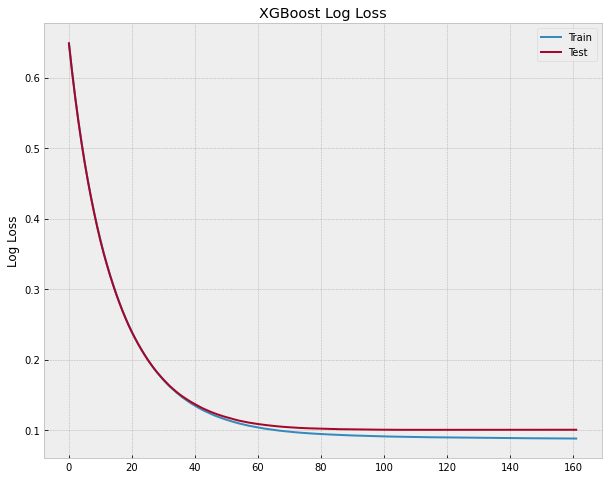

Text(0, 0.5, 'Classification Error')

Text(0.5, 1.0, 'XGBoost Classification Error')

<Figure size 720x720 with 0 Axes>

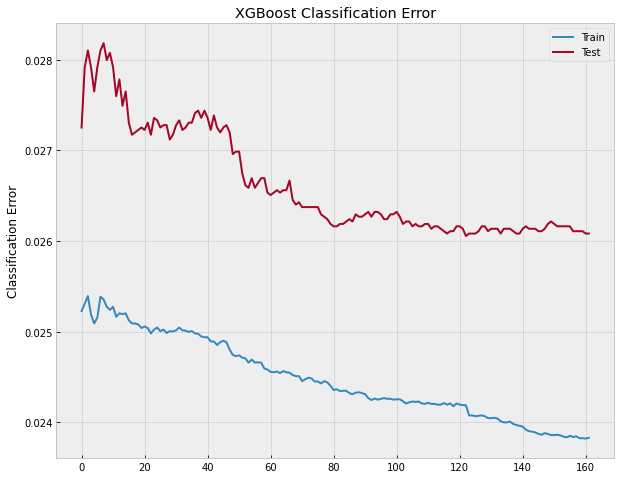

<Figure size 720x720 with 0 Axes>

In [92]:
y_pred = xgb_model.predict(val.drop(columns=['Loan_ID','month','paid_flag']))
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(val['paid_flag'], predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = xgb_model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss

fig, ax = pyplot.subplots(figsize=(10, 8))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')

pyplot.show()
# plot classification error

fig, ax = pyplot.subplots(figsize=(10, 8))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
plt.figure(figsize=(10, 10))
pyplot.show()

#### Saving Model

In [93]:
# file_name = "KB_RR_xgb_v1.pkl"
# pickle.dump(xgb_model, open(file_name, "wb"))

## Model Resutls

### AUC Score 

<Figure size 720x432 with 0 Axes>

Text(0, 0.5, 'TP rate')

Text(0.5, 0, 'FP rate')

Text(0.5, 1.0, 'ROC Curve')

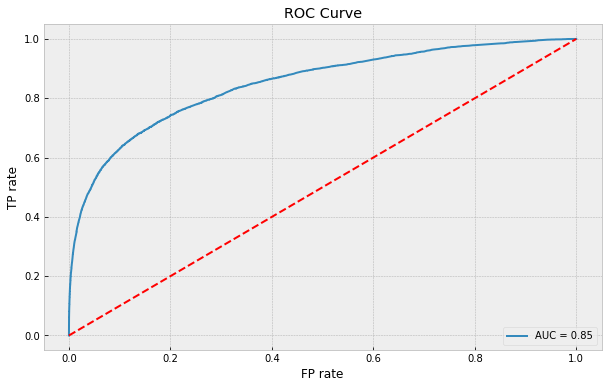

In [94]:
y_pred = xgb_model.predict_proba(train.drop(columns=['Loan_ID','month','paid_flag']))[:,1]
fp_r, tp_r, t = metrics.roc_curve(train['paid_flag'], y_pred)
#tp_r, fpr, t = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(10, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()

<Figure size 720x432 with 0 Axes>

Text(0, 0.5, 'TP rate')

Text(0.5, 0, 'FP rate')

Text(0.5, 1.0, 'ROC Curve')

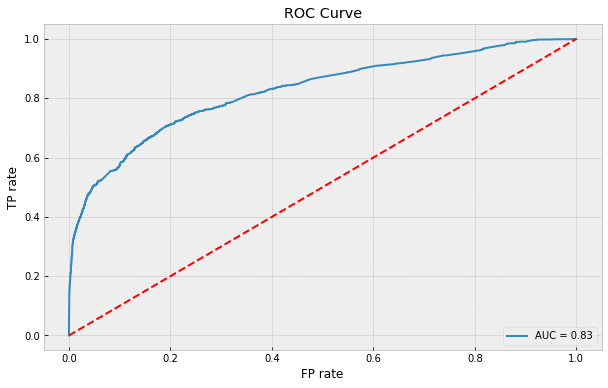

In [95]:
y_pred = xgb_model.predict_proba(val.drop(columns=['Loan_ID','month','paid_flag']))[:,1]
fp_r, tp_r, t = metrics.roc_curve(val['paid_flag'], y_pred)
#tp_r, fpr, t = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(10, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()

### Confusion Matrix 

In [96]:
t_opt=0.5
print("Threshold value is: %.2f" % t_opt)

Threshold value is: 0.50


In [97]:
y_pred = (xgb_model.predict_proba(train.drop(columns=['Loan_ID','month','paid_flag']))[:,1] >=t_opt).astype(bool)
y_test_pred = (xgb_model.predict_proba(val.drop(columns=['Loan_ID','month','paid_flag']))[:,1] >=t_opt).astype(bool)

In [98]:
## training data classification report
print(metrics.classification_report(train['paid_flag'], y_pred))
print(metrics.confusion_matrix(train['paid_flag'], y_pred))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    229182
         1.0       0.77      0.10      0.18      6148

    accuracy                           0.98    235330
   macro avg       0.87      0.55      0.59    235330
weighted avg       0.97      0.98      0.97    235330

[[228989    193]
 [  5503    645]]


In [99]:
## validation data classification report
print(metrics.classification_report(val['paid_flag'], y_test_pred))
print(metrics.confusion_matrix(val['paid_flag'], y_test_pred))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99     36512
         1.0       0.85      0.13      0.22      1099

    accuracy                           0.97     37611
   macro avg       0.91      0.56      0.60     37611
weighted avg       0.97      0.97      0.96     37611

[[36487    25]
 [  958   141]]


### Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

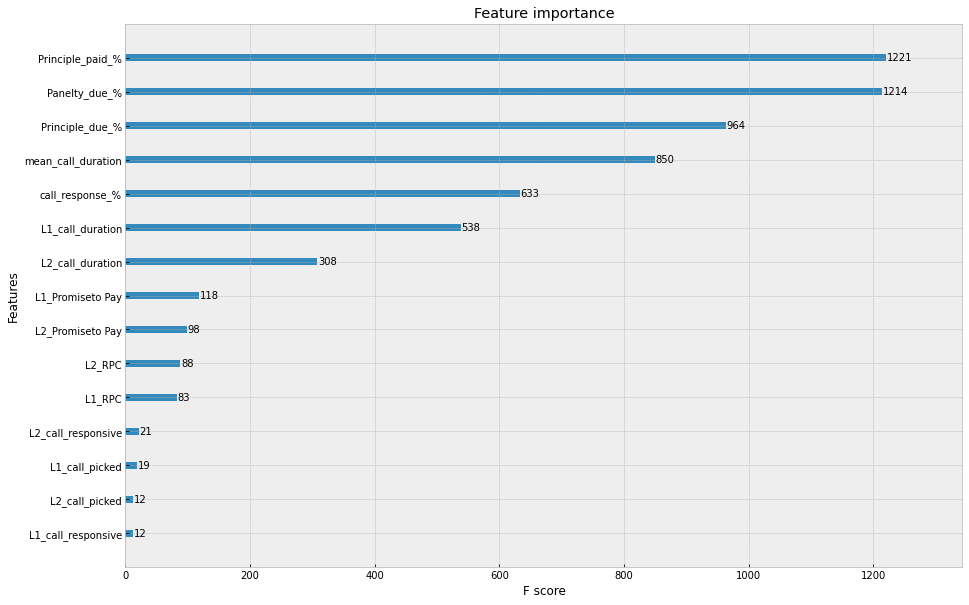

In [100]:
plt.rcParams["figure.figsize"] = (15, 10)
plot_importance(xgb_model)
plt.show()

### KS Score 

In [101]:
y_pred = xgb_model.predict_proba(train.drop(columns=['Loan_ID','month','paid_flag']))[:,1]
y_val_pred = (xgb_model.predict_proba(val.drop(columns=['Loan_ID','month','paid_flag']))[:,1])

train['prob']=list(y_pred)
val['prob']=list(y_val_pred)

#### Train

In [102]:
ks(data=train,target='paid_flag', prob='prob').reset_index()

KS is 54.2% at decile 2


,Decile,min_prob,max_prob,events,...,nonevent_rate,cum_eventrate,cum_noneventrate,KS
0,1,0.045365,0.910484,3734.0,...,8.64%,60.74%,8.64%,52.1
1,2,0.026167,0.045363,743.0,...,9.94%,72.82%,18.58%,54.2
2,3,0.019596,0.026167,450.0,...,10.07%,80.14%,28.65%,51.5
3,4,0.016179,0.019596,365.0,...,10.11%,86.08%,38.76%,47.3
4,5,0.013776,0.016179,240.0,...,10.16%,89.98%,48.93%,41.1
5,6,0.011537,0.013776,165.0,...,9.92%,92.66%,58.84%,33.8
6,7,0.010169,0.011537,184.0,...,10.43%,95.66%,69.28%,26.4
7,8,0.008936,0.010168,136.0,...,10.24%,97.87%,79.52%,18.4
8,9,0.006934,0.008935,79.0,...,10.12%,99.15%,89.64%,9.5
9,10,0.004572,0.006934,52.0,...,10.36%,100.00%,100.00%,-0.0


#### Val

In [103]:
ks(data=val,target='paid_flag', prob='prob').reset_index()

KS is 51.4% at decile 2


,Decile,min_prob,max_prob,events,...,nonevent_rate,cum_eventrate,cum_noneventrate,KS
0,1,0.040096,0.874272,610.0,...,8.34%,55.51%,8.34%,47.2
1,2,0.021398,0.040093,156.0,...,9.99%,69.70%,18.33%,51.4
2,3,0.013032,0.021395,77.0,...,10.26%,76.71%,28.59%,48.1
3,4,0.011330,0.013031,62.0,...,10.07%,82.35%,38.67%,43.7
4,5,0.009804,0.011327,50.0,...,10.22%,86.90%,48.89%,38.0
5,6,0.009442,0.009803,33.0,...,8.53%,89.90%,57.41%,32.5
6,7,0.009212,0.009427,28.0,...,10.72%,92.45%,68.14%,24.3
7,8,0.009042,0.009212,31.0,...,9.53%,95.27%,77.67%,17.6
8,9,0.005982,0.009037,42.0,...,12.05%,99.09%,89.72%,9.4
9,10,0.004860,0.005976,10.0,...,10.28%,100.00%,100.00%,-0.0


### Shap Explainbility

#### Train 

In [107]:
train

,month,Loan_ID,mean_call_duration,call_response_%,...,paid_flag,prob,target0,bucket
0,1,1201,15.92,30.77,...,0.0,0.019531,1.0,"(0.0162, 0.0196]"
1,1,6440,0.00,0.00,...,0.0,0.015091,1.0,"(0.0138, 0.0162]"
2,1,16370,0.00,0.00,...,0.0,0.010034,1.0,"(0.00894, 0.0102]"
3,1,21088,38.45,36.36,...,0.0,0.030718,1.0,"(0.0262, 0.0454]"
4,1,35725,11.00,16.67,...,0.0,0.014023,1.0,"(0.0138, 0.0162]"
...,...,...,...,...,...,...,...,...,...
235833,6,200344560,2.92,7.69,...,0.0,0.007819,1.0,"(0.00693, 0.00894]"
235834,6,200234848,0.00,0.00,...,0.0,0.005660,1.0,"(0.0035700000000000003, 0.00693]"
235835,6,200229530,0.00,0.00,...,0.0,0.006529,1.0,"(0.0035700000000000003, 0.00693]"
235836,6,200612062,0.00,0.00,...,0.0,0.008787,1.0,"(0.00693, 0.00894]"


In [104]:
import shap

In [105]:
explainer = shap.TreeExplainer(xgb_model)

In [108]:
shap_values = explainer.shap_values(train.drop(['Loan_ID','month','paid_flag','prob','target0','bucket'],axis=1))

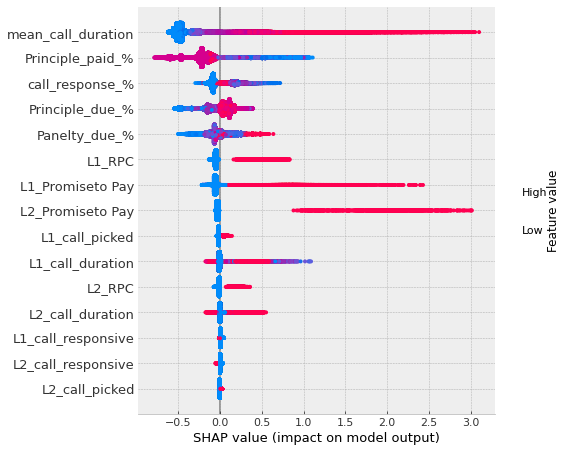

In [109]:
shap.summary_plot(shap_values, train.drop(['Loan_ID','month','paid_flag','prob','target0','bucket'],axis=1), max_display=15)


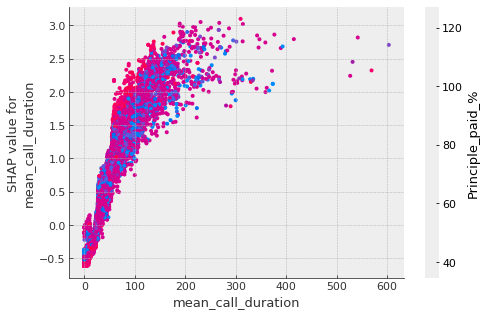

In [110]:
shap.dependence_plot("mean_call_duration", shap_values, train.drop(['Loan_ID','month','paid_flag','prob','target0','bucket'],axis=1))


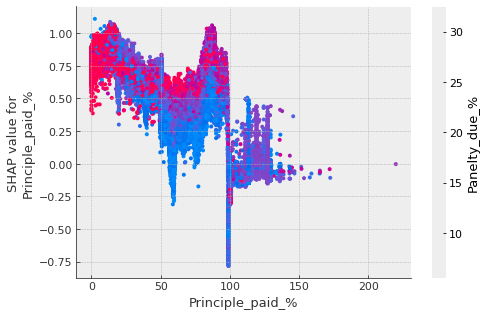

In [111]:
shap.dependence_plot("Principle_paid_%", shap_values, train.drop(['Loan_ID','month','paid_flag','prob','target0','bucket'],axis=1))


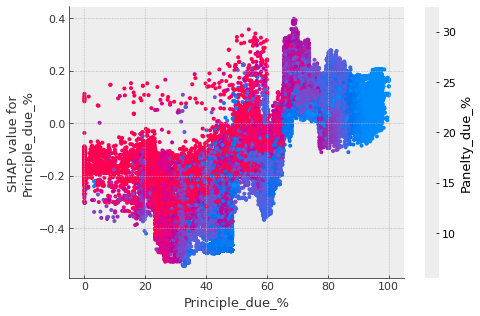

In [112]:
shap.dependence_plot("Principle_due_%", shap_values, train.drop(['Loan_ID','month','paid_flag','prob','target0','bucket'],axis=1))


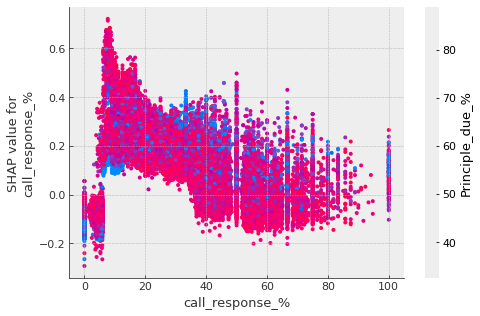

In [113]:
shap.dependence_plot("call_response_%", shap_values, train.drop(['Loan_ID','month','paid_flag','prob','target0','bucket'],axis=1))


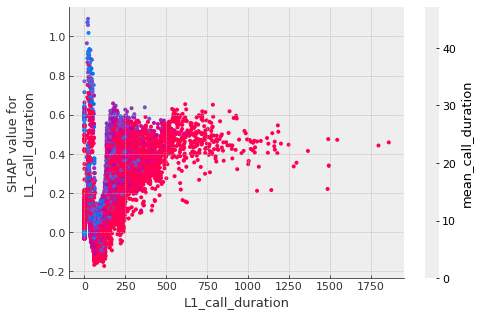

In [114]:
shap.dependence_plot("L1_call_duration", shap_values, train.drop(['Loan_ID','month','paid_flag','prob','target0','bucket'],axis=1))


#### Validation

In [116]:
import shap

In [117]:
explainer = shap.TreeExplainer(xgb_model)

In [118]:
shap_values = explainer.shap_values(val.drop(['Loan_ID','month','paid_flag','prob','target0','bucket'],axis=1))

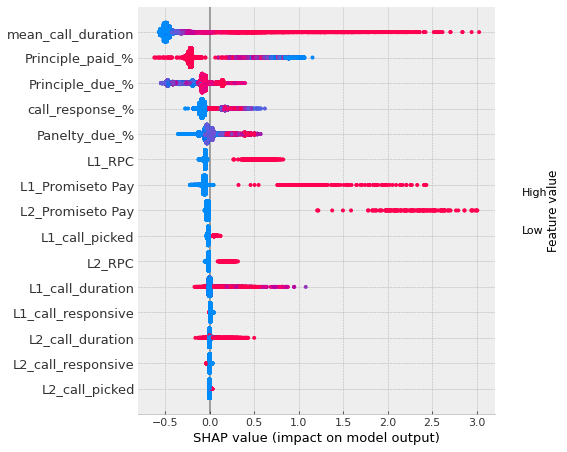

In [119]:
shap.summary_plot(shap_values, val.drop(['Loan_ID','month','paid_flag','prob','target0','bucket'],axis=1), max_display=15)


In [120]:
val.shape

(37611, 21)

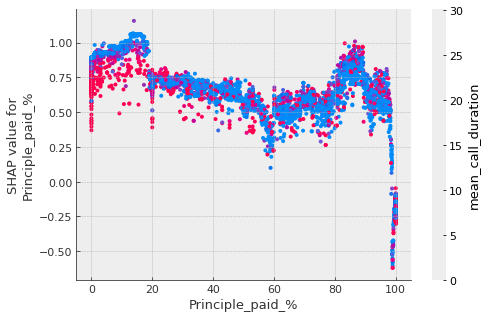

In [121]:
shap.dependence_plot("Principle_paid_%", shap_values, val.drop(['Loan_ID','month','paid_flag','prob','target0','bucket'],axis=1))


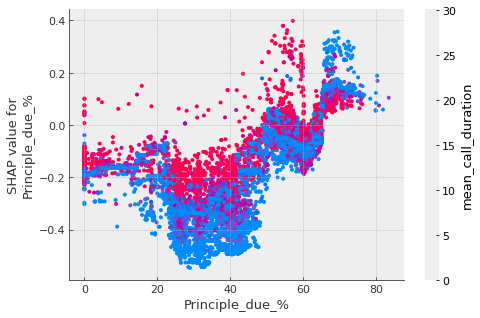

In [122]:
shap.dependence_plot("Principle_due_%", shap_values, val.drop(['Loan_ID','month','paid_flag','prob','target0','bucket'],axis=1))


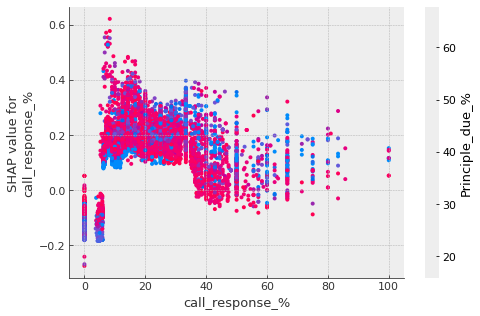

In [123]:
shap.dependence_plot("call_response_%", shap_values, val.drop(['Loan_ID','month','paid_flag','prob','target0','bucket'],axis=1))


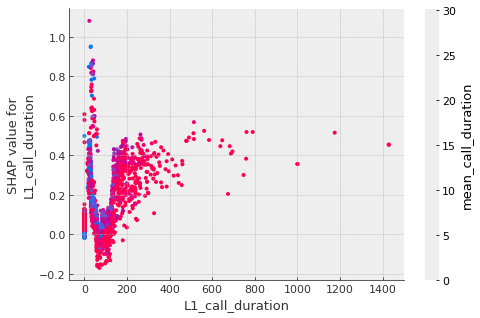

In [124]:
shap.dependence_plot("L1_call_duration", shap_values, val.drop(['Loan_ID','month','paid_flag','prob','target0','bucket'],axis=1))


### conversion / precision / recall on top 1%, 5%, 10% and 30% 

#### Train

In [127]:
y_train_pred = (xgb_model.predict_proba(train.drop(columns=['Loan_ID','month','paid_flag','prob','target0','bucket']))[:,1])
train_pred_label = (xgb_model.predict_proba(train.drop(columns=['Loan_ID','month','paid_flag','prob','target0','bucket']))[:,1] >=t_opt).astype(int)
df_train=pd.DataFrame({'prob':y_train_pred,'pred_label':train_pred_label,'actual_label':train['paid_flag']})
df_train=df_train.sort_values('prob',ascending=False).reset_index()

total_1=sum(df_train['actual_label'])

print("Results on top 1% data : ")
df_temp=df_train[:math.ceil(len(df_train)/100*1)]
total_sub_1=sum(df_train['actual_label'])
print("precision : ",sum(df_temp['actual_label'])/len(df_temp)*100)
print("recall : ", sum(df_temp['actual_label'])/sum(df_train['actual_label'])*100 , "\n")

print("Results on top 5% data : ")
df_temp=df_train[:math.ceil(len(df_train)/100*5)]
total_sub_1=sum(df_train['actual_label'])
print("precision : ",sum(df_temp['actual_label'])/len(df_temp)*100)
print("recall : ", sum(df_temp['actual_label'])/sum(df_train['actual_label'])*100, "\n")

print("Results on top 10% data : ")
df_temp=df_train[:math.ceil(len(df_train)/100*10)]
total_sub_1=sum(df_train['actual_label'])
print("precision : ",sum(df_temp['actual_label'])/len(df_temp)*100)
print("recall : ",sum(df_temp['actual_label'])/sum(df_train['actual_label'])*100, "\n")

print("Results on top 30% data : ")
df_temp=df_train[:math.ceil(len(df_train)/100*30)]
total_sub_1=sum(df_train['actual_label'])
print("precision : ",sum(df_temp['actual_label'])/len(df_temp)*100)
print("recall : ", sum(df_temp['actual_label'])/sum(df_train['actual_label'])*100, "\n")



Results on top 1% data : 
precision :  57.009345794392516
recall :  21.828236824983733 

Results on top 5% data : 
precision :  25.12959972805303
recall :  48.09694209499024 

Results on top 10% data : 
precision :  15.867080270258786
recall :  60.73519843851659 

Results on top 30% data : 
precision :  6.978852391676936
recall :  80.13988288874431 



#### Val

In [128]:
y_val_pred = (xgb_model.predict_proba(val.drop(columns=['Loan_ID','month','paid_flag','prob','target0','bucket']))[:,1])
val_pred_label = (xgb_model.predict_proba(val.drop(columns=['Loan_ID','month','paid_flag','prob','target0','bucket']))[:,1] >=t_opt).astype(int)
df_val=pd.DataFrame({'prob':y_val_pred,'pred_label':val_pred_label,'actual_label':val['paid_flag']})
df_val=df_val.sort_values('prob',ascending=False).reset_index()

total_1=sum(df_val['actual_label'])

print("Results on top 1% data : ")
df_temp=df_val[:math.ceil(len(df_val)/100*1)]
total_sub_1=sum(df_val['actual_label'])
print("precision : ",sum(df_temp['actual_label'])/len(df_temp)*100)
print("recall : ", sum(df_temp['actual_label'])/sum(df_val['actual_label'])*100, "\n")

print("Results on top 5% data : ")
df_temp=df_val[:math.ceil(len(df_val)/100*5)]
total_sub_1=sum(df_val['actual_label'])
print("precision : ",sum(df_temp['actual_label'])/len(df_temp)*100)
print("recall : ", sum(df_temp['actual_label'])/sum(df_val['actual_label'])*100, "\n")

print("Results on top 10% data : ")
df_temp=df_val[:math.ceil(len(df_val)/100*10)]
total_sub_1=sum(df_val['actual_label'])
print("precision : ",sum(df_temp['actual_label'])/len(df_temp)*100)
print("recall : ",sum(df_temp['actual_label'])/sum(df_val['actual_label'])*100, "\n")

print("Results on top 30% data : ")
df_temp=df_val[:math.ceil(len(df_val)/100*30)]
total_sub_1=sum(df_val['actual_label'])
print("precision : ",sum(df_temp['actual_label'])/len(df_temp)*100)
print("recall : ", sum(df_temp['actual_label'])/sum(df_val['actual_label'])*100, "\n")

Results on top 1% data : 
precision :  63.395225464190986
recall :  21.747042766151043 

Results on top 5% data : 
precision :  27.644869750132905
recall :  47.315741583257505 

Results on top 10% data : 
precision :  16.21477937267411
recall :  55.505004549590545 

Results on top 30% data : 
precision :  7.470755051400213
recall :  76.70609645131938 



#### End of code <------------